# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'
save_path = home_path + '\\model\\saved\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'FF01_GP101'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          13
              FF01_GP101          12
temperatures  DC_GT401_GM401      13
              TA01_GT10X_GM10X    14
              DC_GT301_damped     11
              DC_GT301_outdoor    12
setpoints     TA01_GT10X_GM10X    14
sun           gsi                  1
              vol                  1
time          mod                  1
              doy                  1
dtype: int64





In [6]:
# remove single NAN
data = data.dropna(how='any')

In [7]:
# describe cols
data.describe().transpose()

count         mean         std  \
category     sensor_ID                                             
flow         TA01_GP101        256305.0  2350.244315  606.494982   
             FF01_GP101        256305.0  2239.861543  571.441251   
temperatures DC_GT401_GM401    256305.0    49.457762    3.449051   
             TA01_GT10X_GM10X  256305.0    20.744771    1.277303   
             DC_GT301_damped   256305.0    -5.075539    6.692217   
             DC_GT301_outdoor  256305.0    -5.044680    6.653598   
setpoints    TA01_GT10X_GM10X  256305.0    20.661796    0.752597   
sun          gsi               256305.0    29.613705   73.869739   
             vol               256305.0   341.132069  959.526231   
time         mod               256305.0     0.631368    0.306814   
             doy               256305.0     0.316664    0.202923   

                                        min          25%          50%  \
category     sensor_ID                                                  
flow         TA01_GP101        1.761400e+03  1860.000000  2059.000000   
             FF01_GP101        1.358800e+03  1788.900000  1957.100000   
temperatures DC_GT401_GM401    1.540000e+01    48.700000    50.200000   
             TA01_GT10X_GM10X  1.170000e+01    19.900000    20.300000   
             DC_GT301_damped  -2.160000e+01   -10.400000    -3.800000   
             DC_GT301_outdoor -2.090000e+01   -10.300000    -3.700000   
setpoints    TA01_GT10X_GM10X  2.000000e+01    20.000000    20.000000   
sun          gsi               0.000000e+00     0.000000     0.003810   
             vol               0.000000e+00     0.000000     0.000000   
time         mod               0.000000e+00     0.378649     0.697790   
             doy               1.224647e-16     0.128748     0.296713   

                                       75%          max  
category     sensor_ID                                   
flow         TA01_GP101        2738.400000  4206.600000  
             FF01_GP101        2600.800000  4043.600000  
temperatures DC_GT401_GM401      51.200000    56.200000  
             TA01_GT10X_GM10X    21.500000    29.800000  
             DC_GT301_damped      0.100000     9.300000  
             DC_GT301_outdoor     0.300000     8.400000  
setpoints    TA01_GT10X_GM10X    21.500000    22.100000  
sun          gsi                 10.347244   491.320000  
             vol                  0.253372  3600.000000  
time         mod                  0.917060     1.000000  
             doy                  0.501242     0.668064

## Process / transform variables 

In [8]:
# remove erroneous setpoints data
data = data[data.setpoints.TA01_GT10X_GM10X != 0.0]

# # set temp to adjusted for setpoint
# data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
#                                                 - (data.setpoints.TA01_GT10X_GM10X - 20.0)

# ## Use temperature Diff. w.r.t. setpoint
# #data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
# #    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# Transform setpoints variable to instead account for difference w.r.t 20 deg C
data[('temperatures', 'setpoint_diff')] = data.setpoints.TA01_GT10X_GM10X - 20.0

In [9]:
# remove "OUTLIERS" from DC-TEMP
# data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_diff')] = np.abs(data.temperatures.DC_GT401_GM401 - data.temperatures.DC_GT401_GM401_roll)
data.loc[data.temperatures.DC_diff > 2, ('temperatures', 'DC_GT401_GM401')] = data.temperatures.DC_GT401_GM401_roll

In [10]:
# remove "OUTLIERS" from DC-FLOW
data[('flow', 'TA01_GP101')] = data.flow.TA01_GP101.apply(lambda val: max(1800, val))

In [11]:
# perform FFT 
fourier = np.fft.rfft( data.temperatures.DC_GT401_GM401.values)

# get FREQS
spacing = 1 / 100 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1
fourier[freqs > threshold] = 0
filtered = np.fft.irfft(fourier)

# put in data
data.loc[:, ('temperatures', 'DC_GT401_GM401_fft')] = data[('temperatures', 'DC_GT401_GM401')]
data[('temperatures', 'DC_GT401_GM401_fft')].iloc[1:] = filtered

### Plot pairwise correlation matrix

In [13]:
# corr = data.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))

# plt.figure(figsize=(12, 6))
# sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

# plt.xticks(rotation=45)
# plt.title('Pairwise correlation plot')
# plt.show()

# # delete correlation data
# del corr

## Preparing data

In [14]:
t_steps = 20  # 10-min predictions
n_steps = 30  # 15 minute backwards look

train_frac = 0.8

### Data selection and whitening

In [15]:
# # save temp mean & std

# temp_mean = data.temperatures.TA01_GT10X_GM10X.mean()
# temp_std = data.temperatures.TA01_GT10X_GM10X.std()

In [16]:
# # normalize all columns
# for col in data.columns:
#     data[col] = (data[col] - data[col].mean()) / data[col].std()

In [17]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'FF01_GP101'),
    ('temperatures', 'DC_GT401_GM401_fft'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('temperatures', 'setpoint_diff'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter data
data = data[model_vars]

In [18]:
# define target
# targets = data.pop(('temperatures', 'TA01_GT10X_GM10X')).shift(periods=-t_steps)  # 0-minute forward
targets = data[('temperatures', 'TA01_GT10X_GM10X')].copy().shift(periods=-t_steps)

# remove NaNs
targets = targets.iloc[:-t_steps]
data = data.iloc[:-t_steps]

### Create sequences

In [19]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['minute'] = data.index.get_level_values(3).values
    data['date_flag'] = data.minute - data.minute.shift(periods=n_steps) > n_steps / 2

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['minute'], data['date_flag']
    
    return flagged_idx

In [20]:
# get all n_step-sequences from data series
sequences = np.stack([
    data.values[i:i+n_steps, :] for i in range(len(data) - n_steps)
]) 

# get flagged sequences
flags = date_flagger(data, n_steps)

# get mask f. flags
mask = [idx not in flags for idx in range(len(sequences))]
sequences = sequences[mask]

# get targets, delete mask
targets = targets.values[n_steps:][mask]

In [21]:
len(flags)

87

In [22]:
# delete data 
del data

# save sequential seqs, targets for testing
sequences, test_seqs  = sequences[:-8640], sequences[-8640:]
targets, test_targets = targets[:-8640], targets[-8640:]

### Shuffle and split dataset

In [23]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
sequences = np.squeeze(sequences[idxs])
targets = np.squeeze(targets[idxs])


In [24]:
# split data
train_n = int(len(targets) * train_frac)
#test_n = len(targets) - train_n

X_train, X_test = sequences[:train_n], sequences[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [25]:
# delete vars
del sequences, targets

## Define model

In [46]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        activation='tanh',
        return_sequences=True,
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(
        units=64,
#         activation=None,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=64,
#         activation=None,
        activation='relu',
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [47]:
# lr = 0.005
lr = 0.001
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 30, 11)           44        
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 30, 32)            5632      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 32)           128       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128   

In [48]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min"),
#         tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))
    ],
)

Epoch 1/20
1238/1238 [==============================] - 77s 58ms/step - loss: 72.7789 - val_loss: 4.7719
Epoch 2/20
1238/1238 [==============================] - 90s 73ms/step - loss: 4.7374 - val_loss: 4.6622
Epoch 3/20
1238/1238 [==============================] - 66s 54ms/step - loss: 4.5942 - val_loss: 4.5340
Epoch 4/20
1238/1238 [==============================] - 67s 54ms/step - loss: 4.5150 - val_loss: 4.5772
Epoch 5/20
1238/1238 [==============================] - 69s 56ms/step - loss: 4.4787 - val_loss: 4.5171
Epoch 6/20
1238/1238 [==============================] - 63s 51ms/step - loss: 4.4545 - val_loss: 4.4951
Epoch 7/20
1238/1238 [==============================] - 69s 56ms/step - loss: 4.4344 - val_loss: 4.5361
Epoch 8/20
1238/1238 [==============================] - 66s 53ms/step - loss: 4.4429 - val_loss: 4.4886
Epoch 9/20
1238/1238 [==============================] - 84s 68ms/step - loss: 4.4256 - val_loss: 4.4415
Epoch 10/20
1238/1238 [==============================] - 92s 74

In [56]:
model_name = 'temp_model_v6'
model.save(save_path + model_name)

INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_model_v6\assets


INFO:tensorflow:Assets written to: C:\ml_projects\rise-gh.git\rise-gh\model\saved\temp_model_v6\assets


In [49]:
preds = model.predict(X_test)
vis_preds = model.predict(test_seqs)

270/270 [==============================] - 3s 11ms/step


In [50]:
test_mae = np.abs(np.squeeze(preds) - Y_test) 
temp_diffs = test_mae# * temp_std

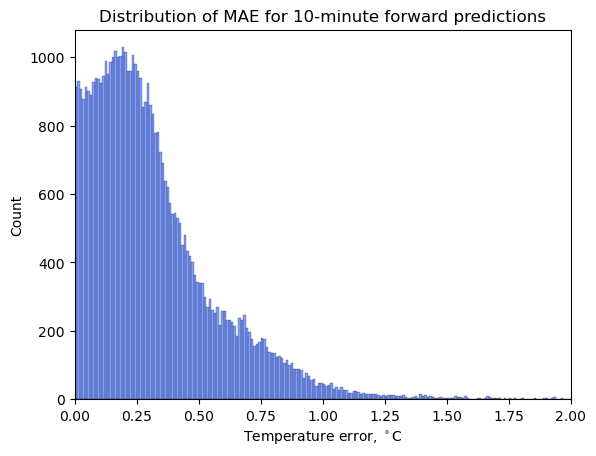

In [51]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 2.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of MAE for 10-minute forward predictions')
plt.xlim(0, 2.0)
plt.xlabel('Temperature error, $^\circ$C')

plt.savefig(plot_path + 'temp_error_dist.png', bbox_inches='tight', dpi=200)
plt.show()

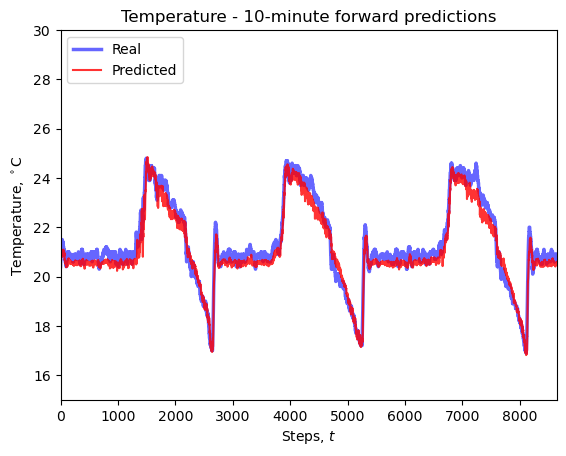

In [52]:
plt.plot(
    np.squeeze(test_targets),# * temp_std + temp_mean,
    c='b',
    alpha=0.6,
    linewidth=2.5,
    label='Real'
)

plt.plot(
    vis_preds,# * temp_std + temp_mean,
    c='r',
    alpha=0.8,
    linewidth=1.5,
    label='Predicted'
)

plt.ylabel('Temperature, $^\circ$C')
plt.xlabel('Steps, $t$')
plt.legend(loc='upper left')
plt.title('Temperature - 10-minute forward predictions')

plt.ylim(15, 30)
plt.xlim(0, len(vis_preds))

plt.savefig(plot_path + 'temp_preds_10min.png', bbox_inches='tight', dpi=200)

plt.show()

In [28]:
model = tf.keras.models.load_model(save_path + '\\temp_model_v6')

In [145]:
ex_seqs = test_seqs.copy()
ex_seqs[:, :, 0] = 7000
ex_seqs[:, :, 1] = 3000
#ex_seqs[:, :, 1] = 45
#ex_seqs[:, :, 3] = 20
ex_preds = model.predict(ex_seqs)

270/270 [==============================] - 2s 6ms/step


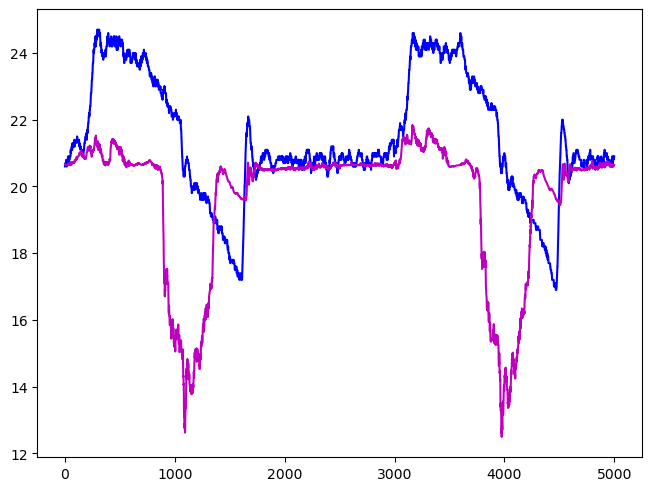

In [146]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(np.squeeze(test_targets)[-5000:], c='b')
ax.plot(ex_preds[-5000:], c='m')

# ax_sec = ax.twinx()

# ax_sec.plot(test_seqs[-8000:, 0, 0], c='r', linewidth=1.5, alpha=0.8)
# ax_sec.set_ylim(0, 5000)
# #plt.plot(test_seqs[-4000:, 0, 0])

plt.show()

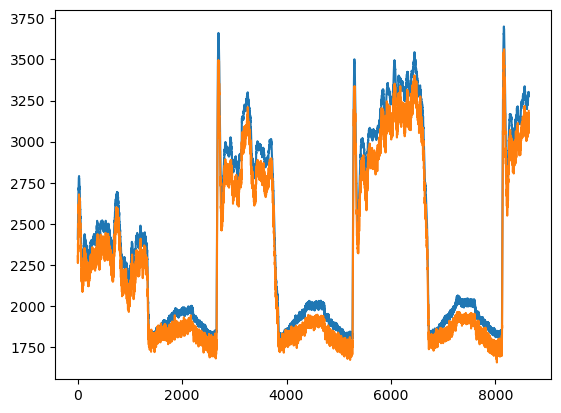

In [148]:
plt.plot(test_seqs[:, -1, 0])
plt.plot(test_seqs[:, -1, 1])
plt.show()

In [54]:
np.corrcoef(test_targets, np.squeeze(vis_preds))

array([[1.        , 0.98215926],
       [0.98215926, 1.        ]])

In [55]:
np.corrcoef(np.squeeze(preds), Y_test)

array([[1.        , 0.96598217],
       [0.96598217, 1.        ]])